# Support Vector Machines

* Maximum Margin Separator
* Support Vector Classifier
* Suppor Vector Machine

In [14]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Import Chicago crime data

In [15]:
df = pd.read_csv("C:/Users/Admin/Desktop/ML_2021/data/chicago-crimes-2019.csv")
df = df.sample(frac=0.02, replace=False, random_state=1)

df.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
62365,11851289,JC461037,10/05/2019 01:00:00 AM,038XX W MADISON ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,True,...,28.0,26.0,02,1150898.0,1899740.0,2019,10/12/2019 04:05:42 PM,41.880779,-87.721377,"(41.880779076, -87.721377025)"


Transform features

In [16]:
print("Found {} NaN community area records.".format(df['Community Area'].isna().sum()))

# There are 4 records in the dataset with NaN Community Area... might not show up in the sample.
df.dropna(inplace=True)
df['Community Area'] = df['Community Area'].astype(float)

Found 0 NaN community area records.


Support Vector Machines

In [17]:
target = df['Arrest'].astype(float)
df['Hour'] = pd.to_datetime(df['Date']).dt.hour

features = df.loc[:,['Primary Type', 'Domestic', 'Community Area','Location Description','Hour']]
features2d = df.loc[:,['Community Area', 'Hour']]
features.head(1)

,Primary Type,Domestic,Community Area,Location Description,Hour
62365,CRIM SEXUAL ASSAULT,True,26.0,APARTMENT,1


sklearn的cross_val_score在遇到Pipeline时，会自动在每一折只用训练集fit每个步骤。

不用Pipeline：编码器提前见过所有数据，导致数据泄漏，评估不准

用Pipeline：每一折只用训练集fit编码器，测试集严格模拟“新数据”，评估更真实

### Label Encoding

In [18]:
# Convert Categorical Features to Numerical Values
features = features.apply(LabelEncoder().fit_transform)
features.head(10)

,Primary Type,Domestic,Community Area,Location Description,Hour
62365,5,1,25,12,1
171879,9,0,1,12,15
145715,28,0,66,79,1
38006,6,0,48,68,15
237592,20,0,0,12,3
149765,27,0,29,82,17
177946,20,1,39,82,14
77056,2,0,42,82,21
23050,27,0,7,48,19
108987,27,0,40,63,12


### One Hot Encoding

In [19]:
# Create a Pipeline.
# All steps except the last one must call 'fit_transform'
# The last step must call 'fit'
lsvc = Pipeline([
    ('ohe', OneHotEncoder()),
    ('svc', LinearSVC(C=1.0,max_iter=100000, class_weight='balanced')),
])

svc = Pipeline([
    ('ohe', OneHotEncoder()),
    ('svc', SVC(kernel='rbf', random_state=0, gamma=0.5, C=1.0, class_weight='balanced')),
])

假设有一个“颜色”特征，取值有“红”、“绿”、“蓝”：
标签编码：
红 → 0
绿 → 1
蓝 → 2
SVM会以为“蓝”比“红”大。
独热编码：
红 → [1, 0, 0]
绿 → [0, 1, 0]
蓝 → [0, 0, 1]
没有顺序和大小关系，模型不会误解。

| 编码方式 | 适用场景 | 是否有顺序关系 | 特征数量变化 | 主要缺点 |
|--------------|-------------------------|----------------|--------------|--------------------|
| 标签编码 | 有顺序的类别/树模型 | 有 | 不变 | 可能引入伪序关系 |
| 独热编码 | 无顺序的类别/大多数模型 | 无 | 增加 | 维度可能变很大 |

In [20]:
# K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=23)

#### Linear Classifier, 2 Features

In [21]:
cv_results = cross_val_score(lsvc,
                             features2d,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

np.float64(0.590215070295017)

#### Radial Basis Classifier, 2 Features

In [22]:
cv_results = cross_val_score(svc,
                             features2d,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

np.float64(0.605997331313787)

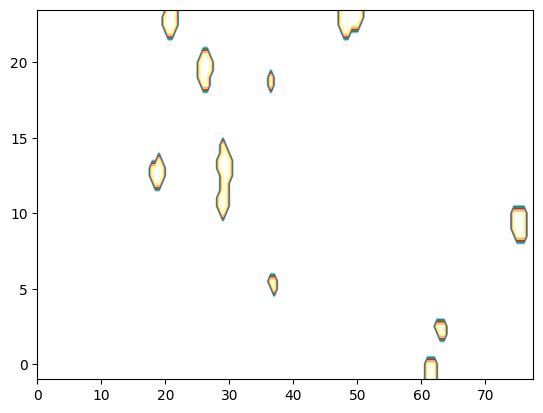

In [23]:
X = features2d.values
Y = target.values

C = 1  # SVM regularization parameter
clf = SVC(kernel = 'rbf',  gamma=0.5, C=C )
clf.fit(X, Y)

h = 0.5  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

#### Linear Classifier, 5 Features

In [24]:
cv_results = cross_val_score(lsvc,
                             features,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metr

np.float64(nan)

In [12]:
cv_results = cross_val_score(svc,
                             features,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metr

np.float64(nan)